# Comparing GPAs of Days of the Week at UW Madison since 2006

This notebook performs a SQL query on the UW Madison database and does a hypothesis test on each day's GPA compared against all of the other days' GPAs

For each day:
* H0 = There is no difference between this day's GPAs and the other days' GPAs
* HA = There is a difference between this day's GPAs and the other days' GPAs

---

## Import necessary Python libraries and modules

In [1]:
from sqlalchemy import create_engine
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from bootstrap import bootstrap

## Query the database to create one overall Pandas dataframe which is then filtered to remove any classes where the GPA is 4.0

In [2]:
engine = create_engine('postgresql:///uw_madison')

In [3]:
query = """SELECT c.uuid, c.name,
                    sch.mon, sch.tues, sch.wed, sch.thurs, sch.fri, sch.sat, sch.sun,
                    subj.name as subject_name,
                    gdc.section_number,

                    (gdc.a_count * 4 + gdc.ab_count * 3.5 + gdc.b_count * 3 + gdc.bc_count * 2.5 + gdc.c_count * 2 + gdc.d_count * 1)
                        / (gdc.a_count + gdc.ab_count + gdc.b_count + gdc.bc_count + gdc.c_count + gdc.d_count + gdc.f_count) AS section_gpa,

                    (gdc.s_count + gdc.u_count + gdc.cr_count + gdc.n_count + gdc.p_count + gdc.i_count + gdc.nw_count + gdc.nr_count 
                        + gdc.other_count) AS non_gpa_count
                FROM schedules AS sch
                JOIN sections ON sch.uuid = sections.schedule_uuid 
                JOIN course_offerings AS c ON sections.course_offering_uuid = c.uuid
                JOIN courses ON c.course_uuid = courses.uuid
                JOIN subject_memberships ON sections.course_offering_uuid = subject_memberships.course_offering_uuid
                JOIN subjects AS subj on subject_memberships.subject_code = subj.code
                JOIN grade_distributions_casted AS gdc ON c.uuid = gdc.course_offering_uuid

            WHERE (gdc.a_count + gdc.ab_count + gdc.b_count + gdc.bc_count + gdc.c_count + gdc.d_count + gdc.f_count) != 0
                AND ((sch.mon = 'true') OR (sch.tues = 'true') OR (sch.wed = 'true') OR (sch.thurs = 'true') 
                OR (sch.fri = 'true') OR (sch.sat = 'true') OR (sch.sun = 'true'))
            GROUP BY c.uuid, c.name, section_gpa, non_gpa_count, sch.mon, sch.tues, sch.wed, sch.thurs, sch.fri, sch.sat, sch.sun, subj.name, gdc.section_number; 
            """

In [4]:
all_days_df = pd.read_sql(query, engine)
all_days_df.describe()

,section_number,section_gpa,non_gpa_count
count,198500.000000,198500.000000,198500.000000
mean,5.571466,3.481093,0.742771
std,12.709275,0.389662,2.570848
min,1.000000,0.000000,0.000000
25%,1.000000,3.197183,0.000000
50%,1.000000,3.514151,0.000000
75%,4.000000,3.822448,1.000000
max,296.000000,4.000000,163.000000


In [5]:
all_days_df.head()

,uuid,name,mon,tues,wed,thurs,fri,sat,sun,subject_name,section_number,section_gpa,non_gpa_count
0,000085b6-0eb9-386e-881e-60cc62be5b62,Adv Hist-Philos: Kant,false,true,false,false,false,false,false,Philosophy,1,4.000000,0
1,00015734-b612-3152-bf5f-7f6855e1c0c0,Fundamentals of Analytical Sci,false,false,true,false,false,false,false,Chemistry,1,3.117647,0
2,00015734-b612-3152-bf5f-7f6855e1c0c0,Fundamentals of Analytical Sci,false,true,false,true,false,false,false,Chemistry,1,3.117647,0
3,0002389b-0bda-3f47-b5e7-e9d8973cb2e9,Corporate&Special Info Serv,true,false,false,false,false,false,false,Library and Information Studies,1,3.818182,0
4,00028b06-6e42-3a3e-b484-69fd61baf978,Spectrochemical Measuremts,true,false,true,false,true,false,false,Chemistry,1,3.425926,0


In [6]:
all_days_df = all_days_df.loc[all_days_df['section_gpa'] != 4.0]

## The overall dataframe is then used to make dataframes for each day and for all other days. E.g. a Monday dataframe with a dataframe for all days besides Monday. Then randomly pick 70 from each dataframe to make plots and conduct hypothesis testing on.

In [7]:
days = ['mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'sun']

In [8]:
gpas = []
p_vals = {}

for day in days:
    day_df = all_days_df.loc[all_days_df[str(day)] == 'true', 'section_gpa']
    day_choice = np.random.choice(day_df, size=70, replace=False)
    
    not_day_df = all_days_df.loc[all_days_df[str(day)] != 'true', 'section_gpa']
    not_day_choice = np.random.choice(not_day_df, size=70, replace=False)
    gpas.append({"day": day_choice, "not_day": not_day_choice})
    p_vals[str(day)] = stats.ttest_ind(day_choice, not_day_choice, equal_var=False)

## Generate plots comparing each day against all other days

In [9]:
full_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

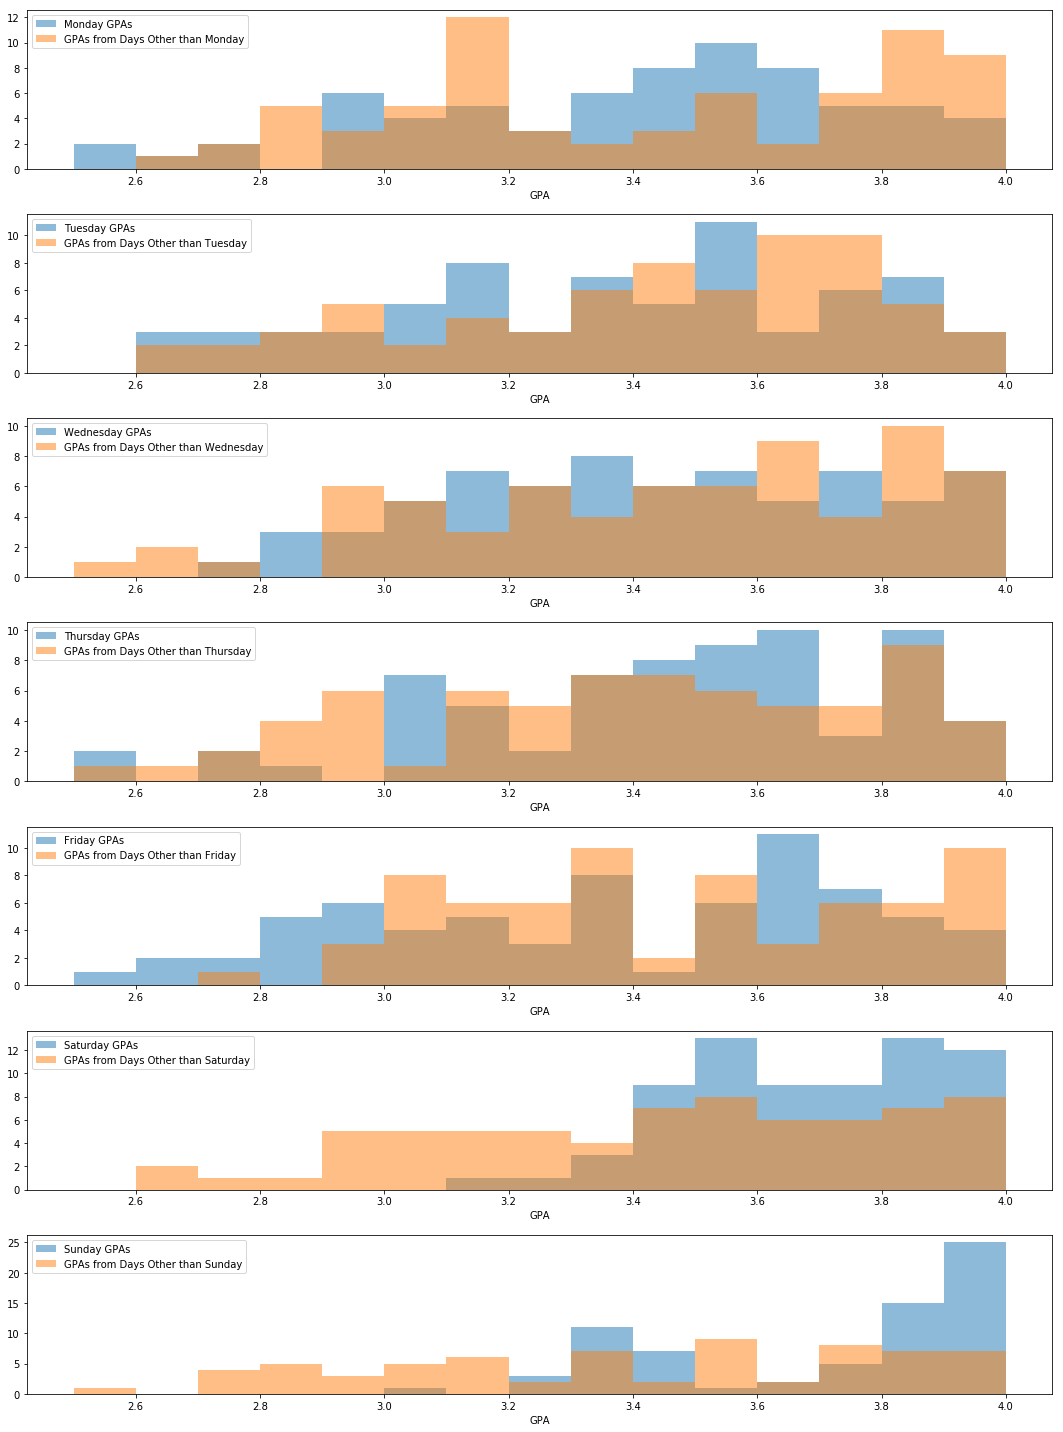

In [10]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(15,20))

counter = 0

for row in range(ax.shape[0]):
    ax[row].hist(gpas[counter]["day"], alpha=0.5, bins=15, range=(2.5, 4.0), label=f'{full_days[counter]} GPAs')
    ax[row].hist(gpas[counter]["not_day"], alpha=0.5, bins=15, range=(2.5, 4.0), label=f'GPAs from Days Other than {full_days[counter]}')
    ax[row].legend()
    ax[row].set_xlabel('GPA');
    counter += 1
    
fig.tight_layout()

## Display the T statistic and p-values for each day against all other days

In [11]:
p_vals

{'mon': Ttest_indResult(statistic=-0.5939035529353549, pvalue=0.5535544928531431),
 'tues': Ttest_indResult(statistic=-0.6602472027141818, pvalue=0.5102067189792514),
 'wed': Ttest_indResult(statistic=-0.2960200982755271, pvalue=0.7676662676608916),
 'thurs': Ttest_indResult(statistic=1.143545061522677, pvalue=0.2548287281005639),
 'fri': Ttest_indResult(statistic=-1.2288313411626166, pvalue=0.22123969538377578),
 'sat': Ttest_indResult(statistic=4.642927506421089, pvalue=9.428462099199783e-06),
 'sun': Ttest_indResult(statistic=5.769922464563611, pvalue=6.982765746255623e-08)}

We can see from the plots and the T statistics of the random samples from the weekday populations that the GPAs are not different to a statistically significant amount. In these cases, we fail to reject the null hypothesis for each weekday.

However, the classes that meet on weekends have GPAs that are statistically distinct from the other days. For Saturday and Sunday, we reject the null hypothesis.